In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion
from sklearn.impute import KNNImputer, MissingIndicator


In [56]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

In [57]:
df_data_dict = pd.read_csv('train_data_dictionary.csv')

In [58]:
stays = df_train['Stay'].unique()
stays.sort()
stays

array(['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70',
       '71-80', '81-90', '91-100', 'More than 100 Days'], dtype=object)

Visualizing the distrobution of the length of stay

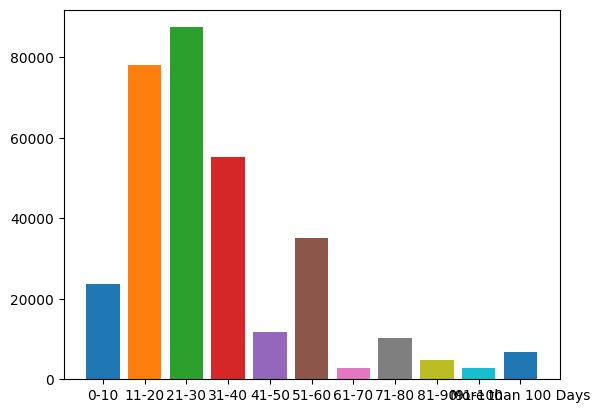

In [59]:
fig, ax = plt.subplots()

for stay in stays:

    count = df_train[df_train['Stay'] == stay].shape[0]
    ax.bar(stay,count)

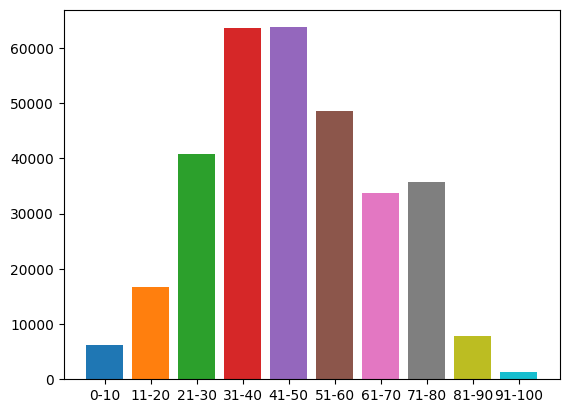

In [60]:
ages = df_train['Age'].unique()
ages.sort()

fig, ax = plt.subplots()

for age in ages:
    count = df_train[df_train['Age'] == age].shape[0]
    ax.bar(age,count)

Assess dataset to try and determine which predictors to use for prediction

In [61]:
df_train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [62]:
df_train['Visitors with Patient'].unique()

array([ 2,  4,  3,  8,  6,  7, 13,  5,  1, 10, 15, 11, 12,  9, 24, 16, 14,
       20,  0, 19, 18, 17, 23, 21, 32, 30, 22, 25])

In [70]:
df_test.dtypes

case_id                                int64
Hospital_code                         object
Hospital_type_code                    object
City_Code_Hospital                    object
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
dtype: object

Note: some categorical values, such as hospital code, are int64, and therefore are being ignored by get dummies

In [64]:
df_train['Hospital_code'] = df_train['Hospital_code'].astype(str)
df_train['City_Code_Hospital'] = df_train['City_Code_Hospital'].astype(str)

df_test['Hospital_code'] = df_test['Hospital_code'].astype(str)
df_test['City_Code_Hospital'] = df_test['City_Code_Hospital'].astype(str)

In [65]:
# Defining what predictors to save for later

predictors = [
    'case_id', 
    'Hospital_code', 
    'Hospital_type_code', 
    'City_Code_Hospital',
    'Hospital_region_code', 
    'Available Extra Rooms in Hospital',
    'Department', 
    'Ward_Type', 
    'Ward_Facility_Code', 
    'Bed Grade',
    'patientid', 
    'City_Code_Patient', 
    'Type of Admission',
    'Severity of Illness', 
    'Visitors with Patient', 
    'Age',
    'Admission_Deposit', 
    ]

Confirming that missing predictors is similar accross data sets

In [66]:
print(f"df_train missing columns {df_train.columns[df_train.isnull().sum() > 0]}")
print(f"df_test missing columns {df_test.columns[df_test.isnull().sum() > 0]}")

df_train missing columns Index(['Bed Grade', 'City_Code_Patient'], dtype='object')
df_test missing columns Index(['Bed Grade', 'City_Code_Patient'], dtype='object')


In [69]:
df_test.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


Add dummy values

In [67]:
train_predictor_dummies = pd.get_dummies(df_train.drop('Stay', axis=1))
# test data also needs to have dummies added
test_predictor_dummies = pd.get_dummies(df_test.drop('Stay', axis=1))



KeyError: "['Stay'] not found in axis"

In [ ]:
train_predictor_dummies

,case_id,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit,Hospital_code_1,Hospital_code_10,Hospital_code_11,...,Stay_11-20,Stay_21-30,Stay_31-40,Stay_41-50,Stay_51-60,Stay_61-70,Stay_71-80,Stay_81-90,Stay_91-100,Stay_More than 100 Days
0,1,3,2.0,31397,7.0,2,4911.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,2,2.0,31397,7.0,2,5954.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,3,2,2.0,31397,7.0,2,4745.0,False,True,False,...,False,False,True,False,False,False,False,False,False,False
3,4,2,2.0,31397,7.0,2,7272.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,5,2,2.0,31397,7.0,2,5558.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,3,4.0,86499,23.0,3,4144.0,False,False,False,...,True,False,False,False,False,False,False,False,False,False
318434,318435,2,4.0,325,8.0,4,6699.0,False,False,False,...,False,False,True,False,False,False,False,False,False,False
318435,318436,3,4.0,125235,10.0,3,4235.0,False,False,False,...,True,False,False,False,False,False,False,False,False,False
318436,318437,3,3.0,91081,8.0,5,3761.0,False,False,True,...,True,False,False,False,False,False,False,False,False,False


Now need to explore collinearity in the training data.

After cell below is ran, data with dummy variables can now be used. All scaling and imputing needs to be done at specific stages, so will be done in a seperate file for clarity

In [ ]:
train_dummies.to_csv("train_dummies.csv")
test_dummies.to_csv("test_dummies.csv")
